<a href="https://colab.research.google.com/github/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/blob/main/offline_open_source_data_reconstruction/tutorials/google_colab/4_GRE2D_ISMRMRD_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline Open-Source Data Reconstruction Exercise

In [1]:
#@title 2D GRE in a  brain phantom - environment setup
# You only need to do this once
!pip show pypulseq || pip install pypulseq &> /dev/null
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr

# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!pip show sigpy || pip install sigpy &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


Timing check passed successfully


<ipython-input-2-29378aea691b>:35: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf, gz, _ = mr.make_sinc_pulse(flip_angle=alpha*np.pi/180, duration=4e-3, slice_thickness=sliceThickness, apodization=0.42, time_bw_product=4.0, system=sys,return_gz=True)
<ipython-input-2-29378aea691b>:41: UserWarning: Specified ADC delay 10.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = mr.make_adc(num_samples=oversamp*Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys) # ADC


'dd4eb34e6edcd26f7fe3bd84618f536f'

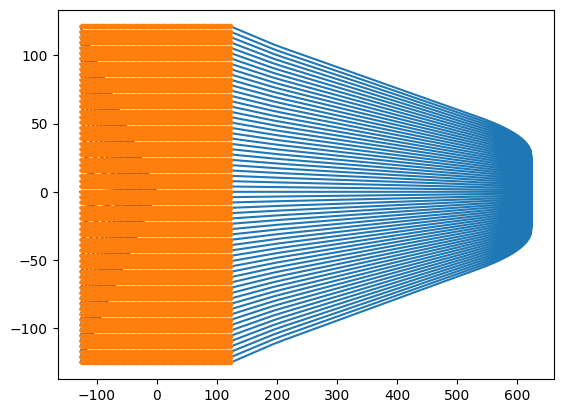

In [2]:
#@title 2D GRE in a brain phantom - sequence

experiment_id = 'gre2d'

# ======
# SETUP SYSTEM
# ======

# set the scanner hardware limits
sys = mr.Opts(
    max_grad=22, grad_unit='mT/m', max_slew=120, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

# Create a sequence object based on the scanner limits
seq = mr.Sequence(sys)

# ======
# DEFINE TIMING, EVENTS, etc.
# ======

# Define FOV, resolution, flip angle, timing, etc.
fov = 256e-3; Nx = 64; Ny = Nx # FOV and resolution
Nrep = 1                        # number of repetition
Nslice = 1                      # number of slices
TE = 6e-3                       # echo time
TR = 20e-3                      # repetition time
alpha = 10                      # flip angle
sliceThickness = 3e-3           # slice thickness
sliceGap = 0                    # slice gap
readout_duration = 5.12e-3      # ADC duration
oversamp = 1                          # readout oversampling

# Create slice-selective RF pulse and gradient
rf, gz, _ = mr.make_sinc_pulse(flip_angle=alpha*np.pi/180, duration=4e-3, slice_thickness=sliceThickness, apodization=0.42, time_bw_product=4.0, system=sys,return_gz=True)
gzReph = mr.make_trapezoid(channel='z', area=-gz.area/2, duration=1e-3, system=sys) # gradient rephaser of the slice-selective gradient (gz)

# Define other gradients and ADC events
deltak = 1/fov
gx = mr.make_trapezoid(channel='x', flat_area=Nx*deltak, flat_time=readout_duration, system=sys) # readout gradient
adc = mr.make_adc(num_samples=oversamp*Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys) # ADC
gxPre = mr.make_trapezoid(channel='x', area=-gx.amplitude*(adc.dwell*(adc.num_samples/2+0.5)+0.5*gx.rise_time), duration=1e-3, system=sys) # prephaser of the readout gradient (gx)

phaseAreas = (np.arange(0, Ny) - Ny / 2) * deltak
gy = mr.make_trapezoid(channel='y', area=np.max(np.abs(phaseAreas)), duration=mr.calc_duration(gxPre), system=sys) ;
peScales = phaseAreas/gy.area ;

# Prepare LABEL for phase encoding
PElbl = range(0, Ny) # Caution: c-style numbering. starting from 0

# Slice positions
slicePositions = (sliceThickness + sliceGap) * (np.arange(0, Nslice) - (Nslice - 1) / 2)
# Spoiling gradient
gxSpoil = mr.make_trapezoid(channel='x', area=2*Nx*deltak,system=sys) ;
gzSpoil = mr.make_trapezoid(channel='z', area=4/sliceThickness, system=sys) ;

# Calculate timing
delayTE = np.ceil((TE - mr.calc_duration(gxPre) - gz.fall_time - gz.flat_time/2 - mr.calc_duration(gx)/2)/seq.grad_raster_time) * seq.grad_raster_time
delayTR = np.ceil((TR - mr.calc_duration(gz) - mr.calc_duration(gxPre) - mr.calc_duration(gx) - delayTE)/seq.grad_raster_time)*seq.grad_raster_time
assert(delayTE >= 0 )
assert(delayTR >= mr.calc_duration(gxSpoil, gy, gzSpoil) )

# ======
# CONSTRUCT SEQUENCE
# ======
for i in range(0, Ny):
  # RF spoiling (vary RF phase pseudo-randomly)
  rand_phase = np.mod(117 * (i**2 + i + 2), 360) * np.pi / 180
  rf.phase_offset = rand_phase
  adc.phase_offset = rand_phase
  seq.add_block(rf, gz) # slice-selective excitation
  seq.add_block(gxPre, mr.scale_grad(gy, peScales[i]), gzReph, mr.make_label(type='SET',label='LIN', value=PElbl[i]))
  seq.add_block(mr.make_delay(delayTE))
  seq.add_block(gx, adc) ;
  seq.add_block(mr.make_delay(delayTR), gxSpoil, mr.scale_grad(gy, -peScales[i]), gzSpoil)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

# Prepare the sequence output for the MRzero simulation
seq.set_definition('Name', 'gre2d')
seq.set_definition('FOV', [fov, fov, np.max(slicePositions)-np.min(slicePositions)+sliceThickness]) ;
seq.set_definition('SlicePositions', slicePositions) ;
seq.set_definition('SliceThickness', sliceThickness) ;
seq.set_definition('SliceGap', sliceGap) ;
seq.write(f"{experiment_id}.seq")

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


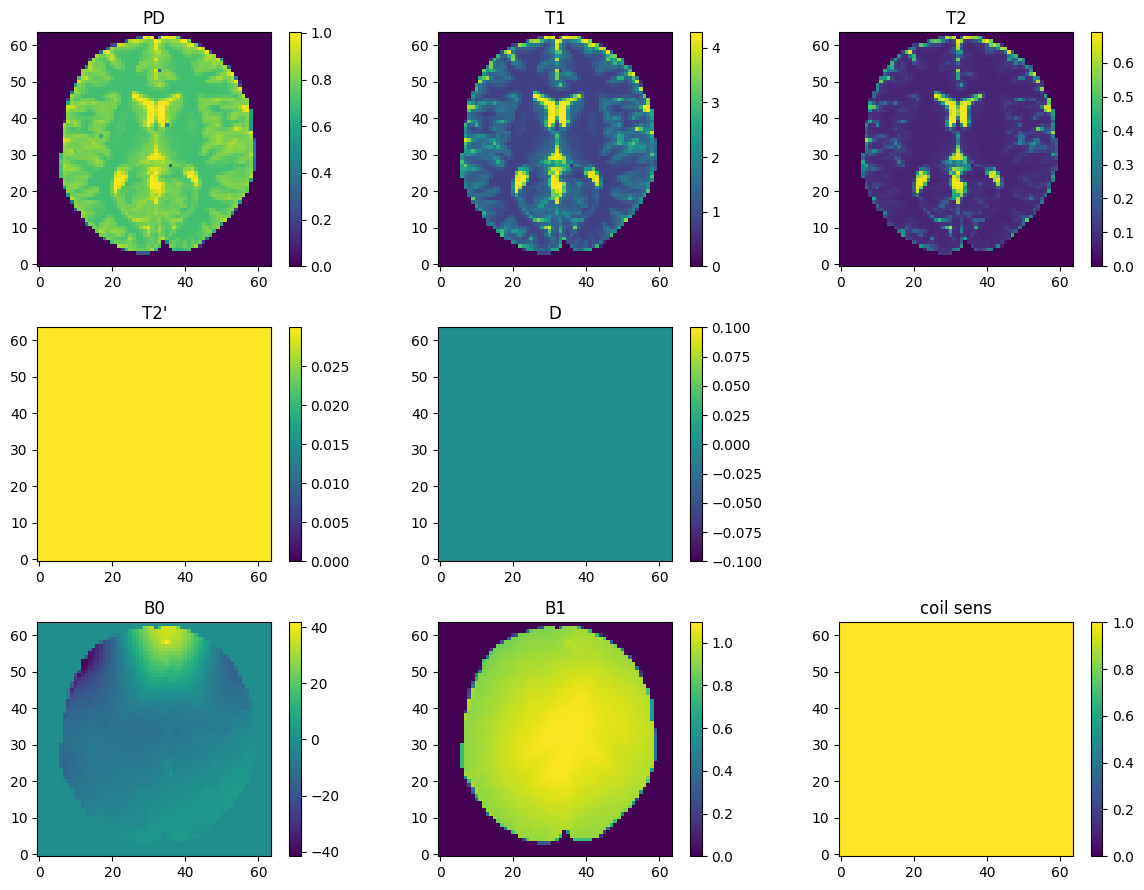

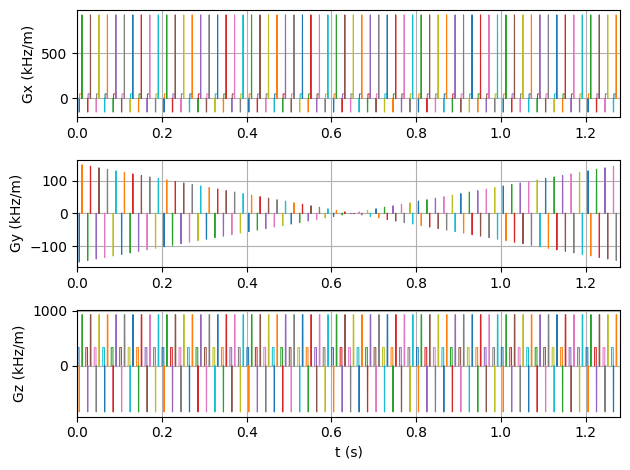

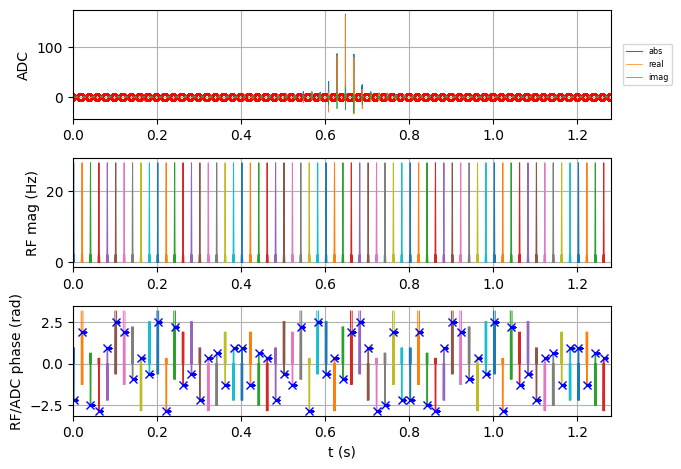

In [3]:
#@title 2D GRE in a brain phantom - simulation
dB0 = 0
sz = [64, 64]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence .seq from above
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file("gre2d.seq")
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(63.5))

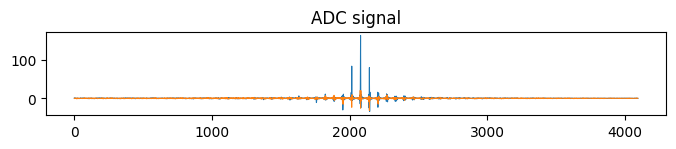

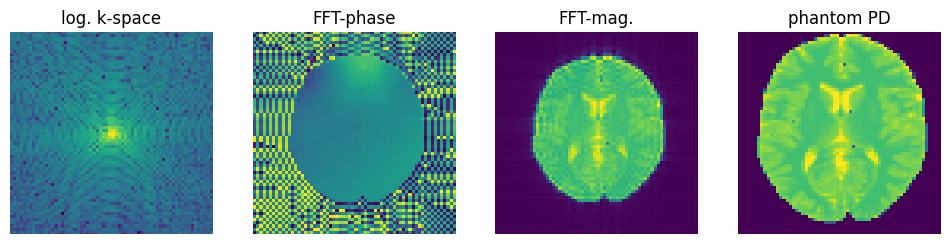

In [4]:
#@title 2D GRE in a brain phantom - manual reconstruction
# 2D FFT
def fft_2d(x):
    return np.fft.ifftshift(np.fft.fftn(np.fft.ifftshift(x)))

kspace = np.reshape(signal, (Ny, oversamp*Nx))
kspace = np.array(kspace)
im = fft_2d(kspace)

fig = plt.figure(figsize=(8, 5))
plt.subplot(411)
plt.title('ADC signal')
plt.plot(np.real(signal), label='real')
plt.plot(np.imag(signal), label='imag')

plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.subplot(141)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace))); plt.axis('off')

plt.subplot(142)
plt.title('FFT-phase')
plt.imshow(np.angle(im), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')

plt.subplot(143)
plt.title('FFT-mag.')
plt.imshow(np.abs(im), origin="lower"); plt.axis('off')

plt.subplot(144)
plt.title('phantom PD')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off')

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


['LIN']


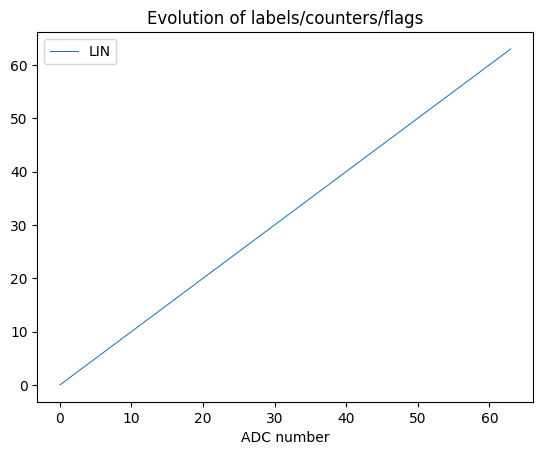

In [5]:
#@title Build ISMRMRD data
!pip show ismrmrd || pip install ismrmrd &> /dev/null
import os
import ismrmrd
import ismrmrd.xsd
from google.colab import files
lbls = seq.evaluate_labels(evolution='adc')
lbl_names = list(lbls.keys())
print(lbl_names)
plt.figure()  # Create a new figure
for name in lbl_names:
    plt.plot(lbls[name])  # Plot each data series

plt.legend(lbl_names)  # Add a legend with the field names
plt.title('Evolution of labels/counters/flags')  # Title
plt.xlabel('ADC number')  # X-axis label
plt.show()  # Display the plot
# plt.savefig('labels.png')
# files.download('labels.png')

LINlbl = lbls['LIN'] # label for phase encoding
Nsample = Nx
Nscan = LINlbl.shape[0]
Ncoil = 1
# Build ISMRMRD data
filename = 'gre2d_mrd_data.h5'

# The number of points in kx,ky
Nkx = oversamp * Nx
Nky = Ny

# Open the dataset
dset = ismrmrd.Dataset(filename, "dataset", create_if_needed=True)

# Create the XML header and write it to the file
header = ismrmrd.xsd.ismrmrdHeader()

# Experimental Conditions
exp = ismrmrd.xsd.experimentalConditionsType()
exp.H1resonanceFrequency_Hz = 128000000
header.experimentalConditions = exp

# Acquisition System Information
sys = ismrmrd.xsd.acquisitionSystemInformationType()
sys.receiverChannels = Ncoil
header.acquisitionSystemInformation = sys

# Encoding
encoding = ismrmrd.xsd.encodingType()
encoding.trajectory = ismrmrd.xsd.trajectoryType('cartesian')

# encoded and recon spaces
efov = ismrmrd.xsd.fieldOfViewMm()
efov.x = oversamp*Nx
efov.y = Ny
efov.z = sliceThickness
rfov = ismrmrd.xsd.fieldOfViewMm()
rfov.x = Nx
rfov.y = Ny
rfov.z = sliceThickness

ematrix = ismrmrd.xsd.matrixSizeType()
ematrix.x = Nkx
ematrix.y = Nky
ematrix.z = 1
rmatrix = ismrmrd.xsd.matrixSizeType()
rmatrix.x = Nx
rmatrix.y = Ny
rmatrix.z = 1

espace = ismrmrd.xsd.encodingSpaceType()
espace.matrixSize = ematrix
espace.fieldOfView_mm = efov
rspace = ismrmrd.xsd.encodingSpaceType()
rspace.matrixSize = rmatrix
rspace.fieldOfView_mm = rfov

# Set encoded and recon spaces
encoding.encodedSpace = espace
encoding.reconSpace = rspace

# Encoding limits
limits = ismrmrd.xsd.encodingLimitsType()

limits1 = ismrmrd.xsd.limitType()
limits1.minimum = 0
limits1.center = round(Ny/2)
limits1.maximum = Ny - 1
limits.kspace_encoding_step_1 = limits1

limits_rep = ismrmrd.xsd.limitType()
limits_rep.minimum = 0
limits_rep.center = round(Nrep / 2)
limits_rep.maximum = Nrep - 1
limits.repetition = limits_rep

limits_rest = ismrmrd.xsd.limitType()
limits_rest.minimum = 0
limits_rest.center = 0
limits_rest.maximum = 0
limits.kspace_encoding_step_0 = limits_rest
limits.slice = limits_rest
limits.average = limits_rest
limits.contrast = limits_rest
limits.kspaceEncodingStep2 = limits_rest
limits.phase = limits_rest
limits.segment = limits_rest
limits.set = limits_rest

encoding.encodingLimits = limits
header.encoding.append(encoding)

dset.write_xml_header(header.toXML('utf-8'))

# Create an acquistion and reuse it
acq = ismrmrd.Acquisition()
acq.resize(Nkx, Ncoil)
acq.version = 1
acq.available_channels = Ncoil
acq.center_sample = round(Nkx/2)
acq.read_dir[0] = 1.0
acq.phase_dir[1] = 1.0
acq.slice_dir[2] = 1.0

# Initialize an acquisition counter
counter = 0
for line in range(Ny):
  # set some fields in the header
  acq.scan_counter = line
  acq.idx.kspace_encode_step_1 = line
  acq.clearAllFlags()
  if line == 0:
    acq.setFlag(ismrmrd.ACQ_FIRST_IN_ENCODE_STEP1)
    acq.setFlag(ismrmrd.ACQ_FIRST_IN_SLICE)
    acq.setFlag(ismrmrd.ACQ_FIRST_IN_REPETITION)
  elif line == Nky - 1:
    acq.setFlag(ismrmrd.ACQ_LAST_IN_ENCODE_STEP1)
    acq.setFlag(ismrmrd.ACQ_LAST_IN_SLICE)
    acq.setFlag(ismrmrd.ACQ_LAST_IN_REPETITION)
  # set the data and append
  acq.data[:] = kspace[line,:]
  dset.append_acquisition(acq)
# Clean up
dset.close()
# print("Saved to %s" % (filename))
# files.download(filename)
